predykcja -> segmentacja -> predykcja z segmentacją i porównanie (może z pca)

Poniżej odtworzenie https://www.kaggle.com/tshephisho/ecommerce-behaviour-using-xgboost/notebook z własnymi zmianami

In [1]:
# data manipulation and visualization
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# model evalution and data preparation
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree

# models
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# settings
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')

In [2]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean.csv", index_col=0)
df_segments = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean_with_segments.csv", index_col=0)

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26560620 entries, 0 to 26560619
Data columns (total 10 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   event_time     26560620 non-null  object 
 1   event_type     26560620 non-null  object 
 2   product_id     26560620 non-null  int64  
 3   category_id    26560620 non-null  int64  
 4   category_code  26560620 non-null  object 
 5   brand          26560620 non-null  object 
 6   price          26560620 non-null  float64
 7   user_id        26560620 non-null  int64  
 8   user_session   26560620 non-null  object 
 9   clusters_3     8116948 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.2+ GB


In [3]:
df = df.merge(df_segments, on='user_id', how='left')
drop_list = ["recency", "frequency", "monetary"]
df = df.drop(drop_list, axis=1)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,clusters_3
0,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,NaN
1,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,NaN
2,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,NaN
3,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,1.0
4,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,NaN


In [5]:
# wybranie wierszy z danym event_type, usunięcie duplikatów z danych kolumn, tak aby w sesji jeden produkt został zakupiony tylko raz
df_final = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_final

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,clusters_3
111,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,2.0
197,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0.0
268,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,0.0
339,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1.0
343,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1.0
...,...,...,...,...,...,...,...,...,...,...
26560296,2019-10-31 23:55:21 UTC,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,0.0
26560347,2019-10-31 23:56:03 UTC,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,0.0
26560358,2019-10-31 23:56:11 UTC,cart,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,0.0
26560403,2019-10-31 23:56:53 UTC,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,0.0


In [6]:
# stworzenie labela czy dany produkt został zakupiony
df_final["is_purchased"] = np.where(df_final["event_type"]=="purchase",1,0)

In [7]:
# danie labela 1 lub 0 w zależności czy produkt po dodaniu do koszyka został zakupiony
df_final["is_purchased"] = df_final.groupby(["user_session","product_id"])["is_purchased"].transform("max")

In [8]:
# ponowne usunięcie duplikatów (zostawienie unikalnych produktów, które zostały dodane do koszyka i kupione), wybranie tylko wierszy z event_type cart
df_final = df_final.loc[df_final["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])

In [9]:
# przygotowanie kolumn z dniem tygodnia oraz godziną eventu
df_final['event_hour'] = pd.to_datetime(df_final['event_time']).dt.hour
df_final['event_weekday'] = df_final['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_final.dropna(how='any', inplace=True)

In [10]:
# stworzenie kolumn z kategoriami i podkategoriami
df_final["category_code_level1"] = df_final["category_code"].str.split(".",expand=True)[0]
df_final["category_code_level2"] = df_final["category_code"].str.split(".",expand=True)[1]

# kategorie trzeciego i czwartego poziomu
# df_xgb["has_category_code_level3"] = df_xgb["category_code"].str.split(".",expand=True)[2]
# df_xgb["has_category_code_level4"] = df_xgb["category_code"].str.split(".",expand=True)[3]
df_final.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,clusters_3,is_purchased,event_hour,event_weekday,category_code_level1,category_code_level2
343,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1.0,1,0,1,electronics,smartphone
398,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,0.0,0,0,1,electronics,audio
810,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,1.0,0,2,1,electronics,smartphone
1029,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,1.0,1,2,1,electronics,smartphone
1047,2019-10-01 02:19:43 UTC,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,0.0,1,2,1,electronics,smartphone


In [11]:
# tylko część produktów posiada kody trzeciego i czwartego poziomu, więc zastąpimy je zerami
# df_xgb["has_category_code_level3"] = np.where(df_xgb["has_category_code_level3"].isnull(), 0, 1)
# df_xgb["has_category_code_level4"] = np.where(df_xgb["has_category_code_level4"].isnull(), 0, 1)

# df_xgb["has_category_code_level3"] = df_xgb['has_category_code_level3'].fillna(0)
# df_xgb["has_category_code_level4"] = df_xgb['has_category_code_level4'].fillna(0)
# df_xgb.head()

In [12]:
# Policzenie aktywności danego użytkownika w sesji
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

print(df_final["clusters_3"].unique())
df_final = df_final.merge(activity_in_session, on='user_session', how='left')
df_final['activity_count'] = df_final['activity_count'].fillna(0)
df_final = df_final.dropna(subset=["clusters_3"])
print(df_final["clusters_3"].unique())

[1. 0. 2.]
[1. 0. 2.]


Usunięcie zbędnych kolumn i ustawienie ich w odpowiedniej kolejności

In [13]:
df_final = df_final.drop(['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'user_id', 'user_session'], axis=1)
new_col_order = ["brand", "category_code_level1", "category_code_level2", "price", "event_weekday", "event_hour", "activity_count", "clusters_3", "is_purchased"]
# new_col_order = ["brand", "category_code_level1", "category_code_level2", "has_category_code_level3", "has_category_code_level4", "price", "event_weekday", "event_hour", "activity_count", "is_purchased"]

df_final = df_final[new_col_order]
df_final.head()

,brand,category_code_level1,category_code_level2,price,event_weekday,event_hour,activity_count,clusters_3,is_purchased
0,apple,electronics,smartphone,515.67,1,0,4,1.0,1
1,apple,electronics,audio,161.98,1,0,4,0.0,0
2,samsung,electronics,smartphone,174.76,1,2,7,1.0,0
3,huawei,electronics,smartphone,258.21,1,2,16,1.0,1
4,samsung,electronics,smartphone,197.43,1,2,10,0.0,1


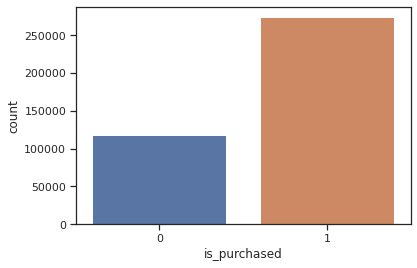

In [14]:
sns.countplot(x="is_purchased", data=df_final)

Zakodowanie zmiennych kategorycznych

In [15]:
df_final.loc[:,'brand'] = LabelEncoder().fit_transform(df_final.loc[:,'brand'].copy())
df_final.loc[:,'event_weekday'] = LabelEncoder().fit_transform(df_final.loc[:,'event_weekday'].copy())
df_final.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(df_final.loc[:,'category_code_level1'].copy())
df_final.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(df_final.loc[:,'category_code_level2'].copy())
# df_final.loc[:,'has_category_code_level3'] = LabelEncoder().fit_transform(df_final.loc[:,'has_category_code_level3'].copy())
# df_final.loc[:,'has_category_code_level4'] = LabelEncoder().fit_transform(df_final.loc[:,'has_category_code_level4'].copy())

# df_final.insert(len(df_final.columns)-1, 'is_purchased', df_final.pop('is_purchased'))
df_final.head()

,brand,category_code_level1,category_code_level2,price,event_weekday,event_hour,activity_count,clusters_3,is_purchased
0,18,7,27,515.67,1,0,4,1.0,1
1,18,7,1,161.98,1,0,4,0.0,0
2,272,7,27,174.76,1,2,7,1.0,0
3,151,7,27,258.21,1,2,16,1.0,1
4,272,7,27,197.43,1,2,10,0.0,1


### Przygotowanie zbalansowanych i niezbalansowanych zbiorów treningowych i testowych

In [16]:
# przygotowanie zbiorów testowych i treningowych
features = df_final.iloc[:, :8]
is_purchased = df_final.iloc[:, 8]

# features = df_xgb.iloc[:, :10]
# is_purchased = df_xgb.iloc[:, 10]

X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 20)

Y_train.value_counts()

1    191799
0     82979
Name: is_purchased, dtype: int64

In [17]:
rus = RandomUnderSampler()

X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)
Y_train_rus.value_counts()

0    82979
1    82979
Name: is_purchased, dtype: int64

### Logistic regression
Na zbiorze niezbalansowanym

In [27]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)
Y_pred_log = log_reg.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_log))
print("Precision:",metrics.precision_score(Y_test, Y_pred_log))
print("Recall:",metrics.recall_score(Y_test, Y_pred_log))
print("fbeta:",metrics.fbeta_score(Y_test, Y_pred_log, average='weighted', beta=0.5))

Accuracy: 0.6987822897029602
Precision: 0.69919192264325
Recall: 0.9968700523687736
fbeta: 0.535693133215776


Na zbiorze zbalansowanym

In [28]:
log_red_balanced = LogisticRegression(max_iter=1000)
log_red_balanced.fit(X_train_rus, Y_train_rus)
Y_pred_log_rus = log_red_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_log_rus))
print("Precision:",metrics.precision_score(Y_test, Y_pred_log_rus))
print("Recall:",metrics.recall_score(Y_test, Y_pred_log_rus))
print("fbeta:",metrics.fbeta_score(Y_test, Y_pred_log_rus, average='weighted', beta=0.5))

Accuracy: 0.5758903551230448
Precision: 0.72679583721127
Recall: 0.6276945560833029
fbeta: 0.6017231066810359


Bez segmentów

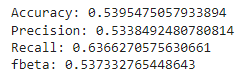

### XGBoost
Na zbiorze niezbalansowanym

In [18]:
model_xgb = XGBClassifier(learning_rate=0.1)
model_xgb.fit(X_train, Y_train)
Y_pred_xgb = model_xgb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_xgb))
print("Precision:", metrics.precision_score(Y_test, Y_pred_xgb))
print("Recall:", metrics.recall_score(Y_test, Y_pred_xgb))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred_xgb, average='weighted', beta=0.5))
print(f"F1 Score: {f1_score(Y_test, Y_pred_xgb, average='macro')}")

Accuracy: 0.7390839150150303
Precision: 0.7317517589752841
Recall: 0.9879673608573865
fbeta: 0.6796423534146786
F1 Score: 0.5593629480380703


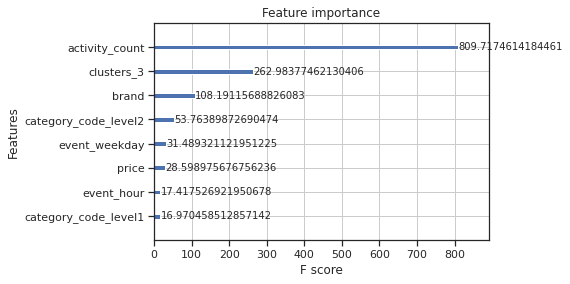

In [19]:
plot_importance(model_xgb, max_num_features=10, importance_type ='gain')
plt.show()

Model trenowany na zbalansowanym zbiorze treningowym

In [ ]:
model_xgb_balanced = XGBClassifier()
model_xgb_balanced.fit(X_train_rus, Y_train_rus)
Y_pred_xgb_rus = model_xgb_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_xgb_rus))
print("Precision:", metrics.precision_score(Y_test, Y_pred_xgb_rus))
print("Recall:", metrics.recall_score(Y_test, Y_pred_xgb_rus))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred_xgb_rus, average='weighted', beta=0.5))
print(f"F1 Score: {f1_score(Y_test, Y_pred_xgb_rus, average='macro')}")

Bez segmentów

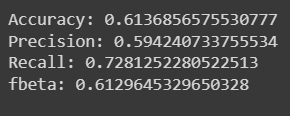

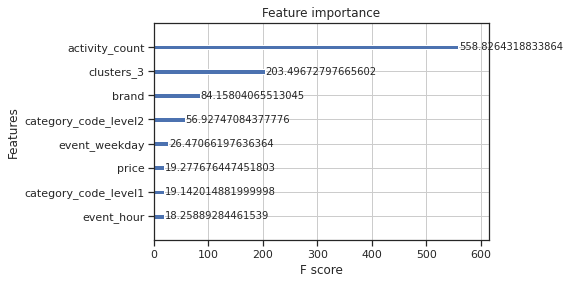

In [21]:
plot_importance(model_xgb_balanced, max_num_features=10, importance_type ='gain')
plt.show()

### LightGBM
Zbiór niezbalansowany

In [23]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, Y_train)
Y_pred_lgbm = lgbm.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_lgbm))
print("Precision:", metrics.precision_score(Y_test, Y_pred_lgbm))
print("Recall:", metrics.recall_score(Y_test, Y_pred_lgbm))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred_lgbm, average='weighted', beta=0.5))
print(f"F1 Score: {f1_score(Y_test, Y_pred_lgbm, average='macro')}")

Accuracy: 0.7398651517467434
Precision: 0.7333792753255232
Recall: 0.9850200949945196
fbeta: 0.6831378363856894
F1 Score: 0.5652516937182733


Zbiór zbalansowany

In [26]:
lgbm_balanced = lgb.LGBMClassifier()
lgbm_balanced.fit(X_train_rus, Y_train_rus)
Y_pred_lgbm_rus = lgbm_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_lgbm_rus))
print("Precision:", metrics.precision_score(Y_test, Y_pred_lgbm_rus))
print("Recall:", metrics.recall_score(Y_test, Y_pred_lgbm_rus))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred_lgbm_rus, average='weighted', beta=0.5))
print(f"F1 Score: {f1_score(Y_test, Y_pred_lgbm_rus, average='macro')}")

Accuracy: 0.6563067882678623
Precision: 0.7873192006183063
Recall: 0.6947509438558032
fbeta: 0.6759955751734852
F1 Score: 0.6191029917993623


Bez segmentów

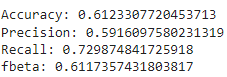

### Decision tree
Zbiór niezbalansowany

In [29]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
Y_dtc_pred = dtc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_dtc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_dtc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_dtc_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_dtc_pred, average='weighted', beta=0.5))

Accuracy: 0.6358163074676042
Precision: 0.7455150915760087
Recall: 0.7252587991718427
fbeta: 0.6408487632391859


In [35]:
# fn=["brand", "category_code_level1", "category_code_level2", "price", "event_weekday", "event_hour", "activity_count", "clusters_3"]
# cn=["bought", "didnt_bought"]

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
# tree.plot_tree(dtc,
#                feature_names = fn, 
#                class_names=cn,
#                filled = True);
# fig.show()

Zbiór zbalansowany

In [30]:
dtc_balanced = DecisionTreeClassifier()
dtc_balanced.fit(X_train_rus, Y_train_rus)
Y_dtc_pred_rus = dtc_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_dtc_pred_rus))
print("Precision:", metrics.precision_score(Y_test, Y_dtc_pred_rus))
print("Recall:", metrics.recall_score(Y_test, Y_dtc_pred_rus))
print("fbeta:", metrics.fbeta_score(Y_test, Y_dtc_pred_rus, average='weighted', beta=0.5))

Accuracy: 0.5625498887586827
Precision: 0.7530227096048562
Recall: 0.5544635245402508
fbeta: 0.6083736493699142


Bez segmentów

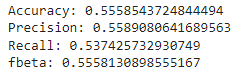

### Random forest
Zbiór niezbalansowany

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_rfc_pred = rfc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_rfc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_rfc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_rfc_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_rfc_pred, average='weighted', beta=0.5))

Accuracy: 0.6941967697559485
Precision: 0.7443961403880819
Recall: 0.8549993910607722
fbeta: 0.6678215542779026


Zbiór zbalansowany

In [32]:
rfc_balanced = RandomForestClassifier()
rfc_balanced.fit(X_train_rus, Y_train_rus)
Y_rfc_pred_rus = rfc_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_rfc_pred_rus))
print("Precision:", metrics.precision_score(Y_test, Y_rfc_pred_rus))
print("Recall:", metrics.recall_score(Y_test, Y_rfc_pred_rus))
print("fbeta:", metrics.fbeta_score(Y_test, Y_rfc_pred_rus, average='weighted', beta=0.5))

Accuracy: 0.5984188447886415
Precision: 0.7738246905424747
Recall: 0.5991840214346609
fbeta: 0.6374163184244939


Bez segmentów

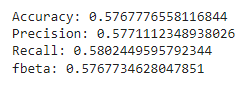

### Naive Bayes
Zbiór niezbalansowany

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_gnb_pred = gnb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_gnb_pred))
print("Precision:", metrics.precision_score(Y_test, Y_gnb_pred))
print("Recall:", metrics.recall_score(Y_test, Y_gnb_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_gnb_pred, average='weighted', beta=0.5))

Accuracy: 0.6911312647543351
Precision: 0.7082153490362466
Recall: 0.9473145780051151
fbeta: 0.6010512751055941


zbiór zbalansowany

In [34]:
gnb_balanced = GaussianNB()
gnb_balanced.fit(X_train_rus, Y_train_rus)
Y_gnb_pred_rus = gnb_balanced.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_gnb_pred_rus))
print("Precision:", metrics.precision_score(Y_test, Y_gnb_pred_rus))
print("Recall:", metrics.recall_score(Y_test, Y_gnb_pred_rus))
print("fbeta:", metrics.fbeta_score(Y_test, Y_gnb_pred_rus, average='weighted', beta=0.5))

Accuracy: 0.6361899424262496
Precision: 0.7250077357690501
Recall: 0.7704542686639874
fbeta: 0.6234624107069593


Bez segmentów

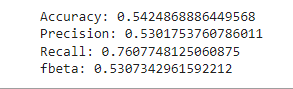